In [152]:
import jax.numpy as jnp

import make_df

import matplotlib.pyplot as plt
import matplotlib as mpl

In [153]:
def fun(x):
    return (x[:,0]**2 + x[:,1] - 11)**2 / 800.0 + (x[:,0] + x[:,1]**2 -7)**2 / 800.0

In [154]:
# sparsification
sparse = True
mode = "optim"
subset_size = 0.02
sparse_dict = {0.1: "log_sparse_0_1", 0.02: "log_sparse_0_02", 0.3: "log_sparse_0_3", 0.005: "log_sparse_0_005"}

if sparse:
    # directory where to save stuff
    in_dir = f"./sparse/{mode}/{sparse_dict[subset_size]}"

    # How many derivative observations should be chosen
    list_d_vals = [200, 400, 800, 1500, 2000, 3000]
else:
    # directory where to save stuff
    in_dir = "./full"
    # How many derivative observations should be chosen
    list_d_vals = [5, 20, 50, 100, 200, 400, 800]


# optimizer type
optimizers = ["L-BFGS-B", "TNC", "SLSQP"]

# name of the function
name = "him"

# How many function observations should be chosen
list_f_vals = [1, 5, 20, 50]

# Grid on which to evaluate the function
bounds = jnp.array([[-5.0, -5.0], [5.0, 5.0]])
eval_grid = jnp.linspace(bounds[0], bounds[1],100).T
eval_grid = jnp.array(jnp.meshgrid(*eval_grid)).reshape(2,-1).T

In [ ]:
def cti(x):
    return x/2.54

In [155]:
def data_full():
    in_dir = f"./full/log_full"
    data = make_df.make_df(list_f_vals, list_d_vals, optimizers, in_dir, name, False, sparse, fun, eval_grid)
    opt_data = data[data["opt"] == optimizers[0]]

    median_mse = []
    mean_mse = []
    std_mse = []
    min_mse = []
    max_mse = []

    for f in opt_data["f"].unique():
        temp = opt_data[opt_data["f"] == f]

        median_mse.append(list(temp["median_mse"]))
        mean_mse.append(list(temp["mean_mse"]))
        std_mse.append(list(temp["std_mse"]))
        min_mse.append(list(temp["min_mse"]))
        max_mse.append(list(temp["max_mse"]))

    return jnp.array(median_mse), jnp.array(mean_mse), jnp.array(std_mse), jnp.array(min_mse), jnp.array(max_mse)

In [196]:
mode_list = ["optim", "rand", "even"]
optimizers = ["SLSQP"]

sparse_list = [0.02, 0.1, 0.3]

list_f_vals = [1, 5, 20, 50]
list_d_vals = [200, 400, 800, 1500, 2000, 3000]

colors = ["r", "g", "b"]

## Compare different sparsifications

In [197]:
def data_different_sparse():
    medians = []
    means = []
    stds = []
    mins = []
    maxs = []

    for sparse in sparse_list:
        in_dir = f"./sparse/{mode}/{sparse_dict[sparse]}"
        data = make_df.make_df(list_f_vals, list_d_vals, optimizers, in_dir, name, True, sparse, fun, eval_grid)
        opt_data = data[data["opt"] == optimizers[0]]

        median_mse = []
        mean_mse = []
        std_mse = []
        min_mse = []
        max_mse = []

        for f in opt_data["f"].unique():
            temp = opt_data[opt_data["f"] == f]

            median_mse.append(list(temp["median_mse"]))
            mean_mse.append(list(temp["mean_mse"]))
            std_mse.append(list(temp["std_mse"]))
            min_mse.append(list(temp["min_mse"]))
            max_mse.append(list(temp["max_mse"]))

        medians.append(median_mse)
        means.append(mean_mse)
        stds.append(std_mse)
        mins.append(min_mse)
        maxs.append(max_mse)

    return jnp.array(medians), jnp.array(means), jnp.array(stds), jnp.array(mins), jnp.array(maxs)
    # shape (sparse_types, n_f, n_d)

### Different plots for different $N_f$

In [198]:
for mode in mode_list:    
    median_mse_sparse, mean_mse_sparse, std_mse_sparse, min_mse_sparse, max_mse_sparse = data_different_sparse()
    median_mse_full, mean_mse_full, std_mse_full, min_mse_full, max_mse_full = data_full()

    plt.rcParams.update({'font.size': 8})

    for i, f in enumerate(list_f_vals):
        fig, ax = plt.subplots(1,1, figsize=(cti(8),cti(6)))

        for j,(c, s) in enumerate(zip(colors, sparse_list)):
            # mean_mse = mean_mse_sparse[j,i]
            median_mse = median_mse_sparse[j,i]
            # std_mse = std_mse_sparse[j,i]
            min_mse = min_mse_sparse[j,i]
            max_mse = max_mse_sparse[j,i]

            ax.plot(list_d_vals, median_mse, color=c, ls="--", marker="x", label=f"sp={s}")
            ax.fill_between(list_d_vals, min_mse, max_mse, alpha=0.2, color=c)
        
        # ax.plot(list_d_vals, mean_mse_full[i], color="magenta", ls="--", marker="x", label=f"full")
        # ax.fill_between(list_d_vals, min_mse_full[i], max_mse_full[i], alpha=0.3, color="magenta")

        ax.set_yscale("log")
        ax.set_xscale("log")
        ax.set_ylim((8e-5,2e1))

        ax.legend()
        ax.grid()

        ax.set_xlabel("$N_g$")
        ax.set_ylabel("$\Omega$")

        ax.set_xticks([200,400,800,1600])
        ax.set_xticklabels([200,400,800,1600])

        plt.tight_layout()
        plt.close()
        fig.savefig(f"./plots/f{f}_{mode}.pdf")
        # fig.savefig(f"./plots/f{f}_{mode}.png", transparent=True)

### Different plots for different $N_g$

In [193]:
# plt.rcParams.update({'font.size': 14})

# for i, d in enumerate(list_d_vals):
#     fig, ax = plt.subplots(1,1, figsize=(8,6))

#     for j,(c, s) in enumerate(zip(colors, sparse_list)):
#         median_mse = median_mse_sparse[j,:,i]
#         min_mse = min_mse_sparse[j,:,i]
#         max_mse = max_mse_sparse[j,:,i]

#         ax.plot(list_f_vals, median_mse, color=c, ls="--", marker="x", label=f"sp={s}")
#         ax.fill_between(list_f_vals, min_mse, max_mse, alpha=0.2, color=c)
    
#     ax.plot(list_f_vals, mean_mse_full[:,i], color="magenta", ls="--", marker="x", label=f"full")
#     ax.fill_between(list_f_vals, min_mse_full[:,i], max_mse_full[:,i], alpha=0.3, color="magenta")

#     ax.set_yscale("log")
#     ax.set_xscale("log")
#     ax.set_ylim((8e-5,2e1))

#     ax.legend()
#     ax.grid()

#     ax.set_xlabel("$N_g$")
#     ax.set_ylabel("$\Omega$")

#     ax.set_xticks([1,2,4,8,16,32])
#     ax.set_xticklabels([1,2,4,8,16,32])

#     plt.close()

#     fig.savefig(f"./plots/d{d}_{mode}.pdf")
#     # fig.savefig(f"./plots/d{d}_{mode}.png", transparent=True)

## Compare different sparse methods

In [163]:
def data_different_mode():
    medians = []
    means = []
    stds = []
    mins = []
    maxs = []

    for mode in mode_list:
        in_dir = f"./sparse/{mode}/{sparse_dict[sparse]}"
        data = make_df.make_df(list_f_vals, list_d_vals, optimizers, in_dir, name, True, sparse, fun, eval_grid)
        opt_data = data[data["opt"] == optimizers[0]]

        median_mse = []
        mean_mse = []
        std_mse = []
        min_mse = []
        max_mse = []

        for f in opt_data["f"].unique():
            temp = opt_data[opt_data["f"] == f]

            median_mse.append(list(temp["median_mse"]))
            mean_mse.append(list(temp["mean_mse"]))
            std_mse.append(list(temp["std_mse"]))
            min_mse.append(list(temp["min_mse"]))
            max_mse.append(list(temp["max_mse"]))

        medians.append(median_mse)
        means.append(mean_mse)
        stds.append(std_mse)
        mins.append(min_mse)
        maxs.append(max_mse)

    return jnp.array(medians), jnp.array(means), jnp.array(stds), jnp.array(mins), jnp.array(maxs)

In [199]:
for sparse in sparse_list:
    median_mse_sparse, mean_mse_sparse, std_mse_sparse, min_mse_sparse, max_mse_sparse = data_different_mode()
    median_mse_full, mean_mse_full, std_mse_full, min_mse_full, max_mse_full = data_full()

    plt.rcParams.update({'font.size': 8})

    for i, f in enumerate(list_f_vals):
        fig, ax = plt.subplots(1,1, figsize=(cti(8),cti(6)))

        for j,(c, m) in enumerate(zip(colors, mode_list)):
            # mean_mse = mean_mse_sparse[j,i]
            median_mse = median_mse_sparse[j,i]
            # std_mse = std_mse_sparse[j,i]
            min_mse = min_mse_sparse[j,i]
            max_mse = max_mse_sparse[j,i]

            ax.plot(list_d_vals, median_mse, color=c, ls="--", marker="x", label=f"mode={m}")
            ax.fill_between(list_d_vals, min_mse, max_mse, alpha=0.2, color=c)
        
        # ax.plot(list_d_vals, mean_mse_full[i], color="magenta", ls="--", marker="x", label=f"full")
        # ax.fill_between(list_d_vals, min_mse_full[i], max_mse_full[i], alpha=0.3, color="magenta")

        ax.set_yscale("log")
        ax.set_xscale("log")
        ax.set_ylim((8e-5,2e1))

        ax.legend()
        ax.grid()

        ax.set_xlabel("$N_g$")
        ax.set_ylabel("$\Omega$")

        ax.set_xticks([200,400,800,1600])
        ax.set_xticklabels([200,400,800,1600])

        plt.tight_layout()
        plt.close()
        fig.savefig(f"./plots/f{f}_{sparse}.pdf")
        # fig.savefig(f"./plots/f{f}_{mode}.png", transparent=True)

# Compare sparse total

In [166]:
mode_list = ["rand", "even", "optim"]
optimizers = ["SLSQP"]

sparse_list = [0.02, 0.1, 0.3]

list_f_vals = [1, 5, 20, 50]
list_d_vals = [200, 400, 800, 1500, 2000, 3000]

colors = ["r", "g", "b"]

In [167]:
def data_sparse():
    medians = []

    for mode in mode_list:
        m_mode = []
        for sparse in sparse_list:
            in_dir = f"./sparse/{mode}/{sparse_dict[sparse]}"
            data = make_df.make_df(list_f_vals, list_d_vals, optimizers, in_dir, name, True, sparse, fun, eval_grid)
            opt_data = data[data["opt"] == optimizers[0]]

            m_sparse = []

            for f in opt_data["f"].unique():
                temp = opt_data[opt_data["f"] == f]

                m_sparse.append(list(temp["median_mse"]))

            m_mode.append(m_sparse)
        medians.append(m_mode)

    return jnp.array(medians)
    # shape = (modes, sparse, N_f, N_g)

In [168]:
median_mse_sparse = data_sparse()

In [169]:
print(median_mse_sparse.shape)

(3, 3, 4, 6)


# Compare Full

In [170]:
median_mse_full, mean_mse_full, std_mse_full, min_mse_full, max_mse_full = data_full()

In [171]:
median_mse_full = jnp.log(median_mse_full)

minimum = float(jnp.min(median_mse_full))
maximum = float(jnp.max(median_mse_full))


cmap = mpl.colormaps['viridis']
norm = mpl.colors.Normalize(vmin=minimum, vmax=maximum)

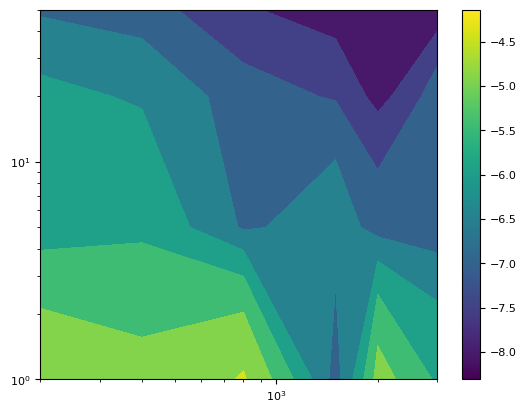

In [172]:
fig, ax = plt.subplots(1,1)

# for i, d in enumerate(list_d_vals):
#     for j, f in enumerate(list_f_vals):
#         ax.scatter(d, f, c=median_mse_full[j,i], cmap=cmap, norm=norm)

ax.contourf(list_d_vals, list_f_vals, median_mse_full)
fig.colorbar(mpl.cm.ScalarMappable(cmap=cmap, norm=norm), ax=ax)

plt.xscale("log")
plt.yscale("log")

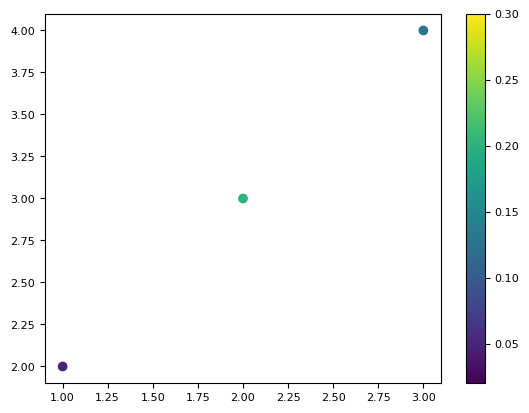

In [173]:
x = [1,2,3]
y = [2,3,4]
c = [0.05, 0.2, 0.13]

slevels = [0.1, 0.02, 0.3]

cmap = mpl.colormaps['viridis']
norm = mpl.colors.Normalize(vmin=min(slevels), vmax=max(slevels))

fig, ax = plt.subplots(1,1)

ax.scatter(x, y, c=c, cmap=cmap, norm=norm)

fig.colorbar(mpl.cm.ScalarMappable(cmap=cmap, norm=norm), ax=ax)